In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate 
import matplotlib.colors

## 1. Interpolation

*Author: Connor Hainje*

> *Interpolation.* Create an image of a critically sampled Gaussian PSF centered at the middle
of a pixel. Create another image of the same PSF, but with its center offset some fraction
of a pixel from the first case. We will test how well different types of interpolation work by
trying to shift the first image using interpolation and comparing it to the second image.
> - (a) Use linear interpolation to try to shift the first image so the PSF has the same center
as in the second image. Compare the absolute and fractional differences (pixel-by-pixel)
between first image shifted and the second image.
> - (b) Perform the same test with sinc interpolation.
> - (c) Perform the same test with a “damped” version of sinc interpolation, which multiplies
the kernel by a broader sinc function; the Lanczos kernel.

### Making the images

"Critically-sampled" means "sampled at the Nyquist rate."

A Gaussian PSF is a two-dimensional Gaussian, which we'll take to be 
symmetric (i.e. $\sigma_x = \sigma_y = \sigma$, no covariance):
$$
\mathcal{G}(\vec{x}; \vec{\mu}, \sigma) = \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{(\vec{x} - \vec{\mu})^2}{2 \sigma^2} \right)
$$

Formally, the Fourier transform of a Gaussian is a Gaussian, which 
has nonzero density as $\vec{k} \to \infty$, meaning that the maximum 
frequency is $\infty$ and the Nyquist rate is also $\infty$. Nevertheless,
in practice the power at very high wavenumbers is small. A good rule of
thumb is that being well-sampled means having at least 2 pixels per FWHM.
This arises from deriving the sampling necessary for the PSF associated 
with a finite  circular aperture (which does have a strict band-limit).

For a Gaussian distribution, the FWHM is $2 \sqrt{2 \ln 2} \; \sigma \approx 2.355 \sigma$. 
Fixing our pixel size to just be 1 pixel (so we can use simply use arrays), we will
set $\text{FWHM} = 2 \ \text{px}$, leading to $\sigma = (2 \ln 2)^{-1/2} \approx 0.85$.

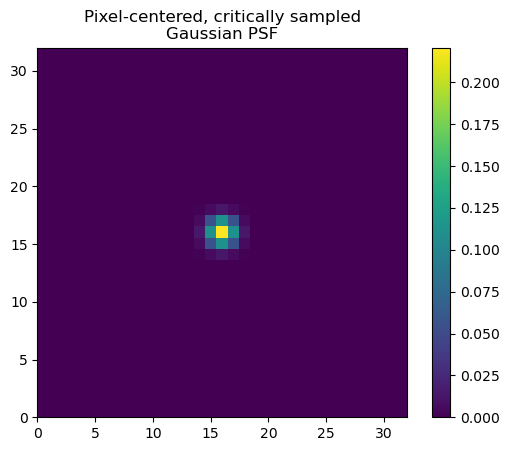

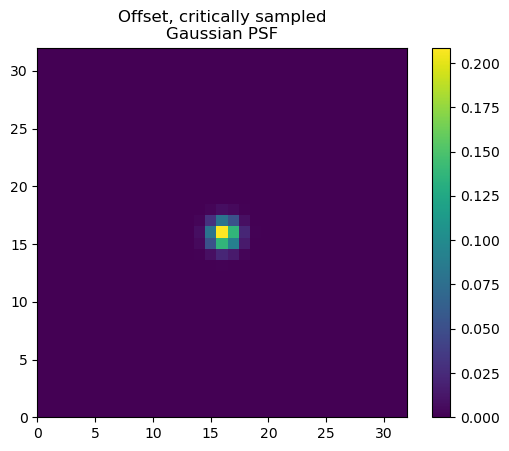

In [2]:
# let's make our critically sampled Gaussian image

def gaussian(x, mu, sigma):
    x = np.atleast_2d(x)
    mu = np.atleast_1d(mu)
    sigma = sigma
    delta_sq = np.square(x - mu).sum(-1)
    return np.exp( -0.5 * delta_sq / sigma**2 ) / (2 * np.pi * sigma**2)

# let's make a critically sampled one, i.e. one with sigma = 1/sqrt(2 ln 2)
sigma = 1. / np.sqrt(2 * np.log(2))

npix = 33

x, y = np.meshgrid(np.arange(npix), np.arange(npix))
X = np.stack((x, y), -1)

# first, we'll center it on the middle of a pixel
mu_1 = np.array([npix // 2, npix // 2])
Z_1 = gaussian(X, mu_1, sigma)
plt.imshow(Z_1, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
plt.title('Pixel-centered, critically sampled\nGaussian PSF')
plt.colorbar()
plt.show()

# next, we'll offset it from the pixel center by 0.2 px in each coordinate
mu_2 = np.array([(npix // 2) + 0.2, (npix // 2) - 0.2])
Z_2 = gaussian(X, mu_2, sigma)
plt.imshow(Z_2, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
plt.title('Offset, critically sampled\nGaussian PSF')
plt.colorbar()
plt.show()

### 1(a): Linear interpolation

We want to use linear interpolation to "re-center" the first image onto the second.

The first image has mean at $\mu_1 = (16, 16)$, where the second has mean $\mu_2 = (16.2, 15.8)$. This can equivalently be expressed in terms of a redefined coordinate system $x' = x - 0.2$, $y' = y + 0.2$, where now $\mu_1' = (16.2, 15.8)$. Hence, we can interpolate image 1 onto this new offset coordinate grid to obtain an estimate of image 2.

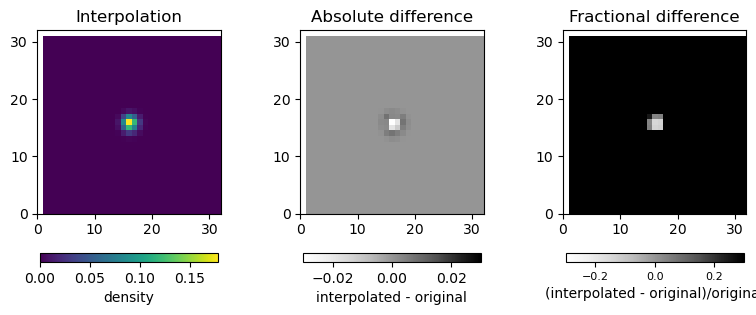

In [9]:
interp = scipy.interpolate.RegularGridInterpolator((np.arange(npix), np.arange(npix)),
                                                   Z_1, method='linear', bounds_error=False, fill_value=np.nan)
new_X = X + np.array([-0.2, +0.2])
Z_3 = interp(new_X)
delta = Z_3 - Z_2
frac_delta = delta / Z_2
vlim = 0.3


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_3, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', norm=matplotlib.colors.CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', vmin=-vlim, vmax=vlim)
           #norm=matplotlib.colors.SymLogNorm(1e-1, vmin=-vlim, vmax=+vlim))
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

In [10]:
np.count_nonzero(np.abs(frac_delta) > 1e-1) / np.prod([frac_delta.shape])

0.9366391184573003

So, even though the interpolated image looks good by eye, it appears that it picks up errors of greater than 10% in most of the pixels. Of course, the absolute values are near zero over many pixels, but more significantly there are 20% errors in the most central pixels.

### 1(b): sinc interpolation

According to [Wikipedia](https://en.wikipedia.org/wiki/Whittaker%E2%80%93Shannon_interpolation_formula), one-dimensional sinc interpolation is given by
$$
x(t) = \sum_{n = -\infty}^{\infty} x[n] \; \text{sinc} \left(\frac{t - nT}{T}\right),
$$
where $\text{sinc}(t) = \sin \pi t/\pi t$, $x(t)$ is the interpolated value, $x[n]$ is a sample point, and $T$ is a parameter which sets the bandlimit $1/2T$. For our purposes, we should take $T$ to be the sampling resolution, which is $1 \ \text{px}$. We also take $x$ and $y$ to be independent for our PSF, so the $\text{sinc}$ kernels in each dimension just multiply. Thus, our interpolation looks like
$$
Z_\text{interp}(x, y) = \sum_{n_x,n_y} Z[x,y] \; \text{sinc} \left(x - n_x\right) \; \text{sinc} \left(y - n_y\right),
$$

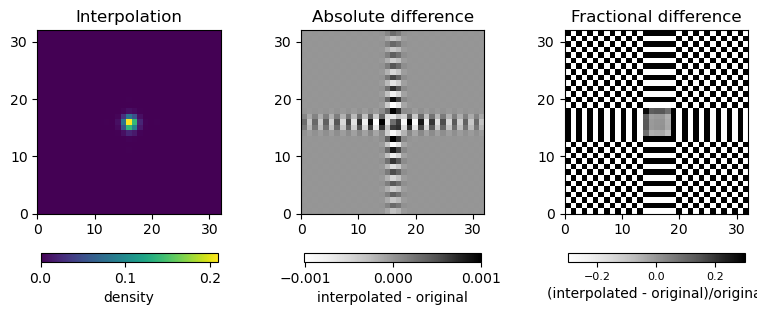

In [11]:
Z_4 = (Z_1[None, None, :, :] * np.prod(np.sinc(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_4 - Z_2
frac_delta = delta / Z_2
vlim = 0.3


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_4, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', norm=matplotlib.colors.CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', vmin=-vlim, vmax=vlim)
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

Again the interpolation looks great by eye, and the absolute errors are much smaller than in the linear case.
But now it looks like we get some _crazy_ fractional errors. The ringing of the sinc function is causing these oscillationsm, and they persist over the whole image.

### 3(c): Lanczos interpolation

The Lanczos kernel is given by
$$
L(x; a) = \mathbb{1}(|x| < a) \;\text{sinc}(x) \;\text{sinc}(x/a),
$$
where $\mathbb{1}(\text{cond})$ is one when $\text{cond}$ is true and zero otherwise, and $a$ is a parameter defining the size of the kernel. We'll try taking $a = 5$.

Again, in 2D, the filters in each coordinate just multiply, so our interpolation looks like this:
$$
Z_\text{interp}(x, y) = \sum_{n_x,n_y} Z[x,y] \; L \left(x - n_x; a\right) \; L \left(y - n_y; a\right),
$$

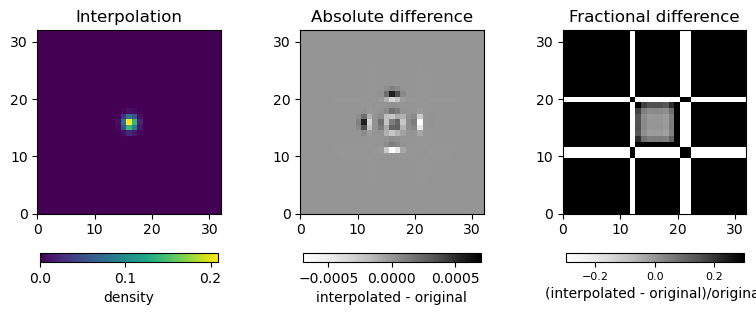

In [12]:
def lanczos(x, a=5):
    return (np.abs(x) < a).astype(float) * np.sinc(x) * np.sinc(x / a)

Z_5 = (Z_1[None, None, :, :] * np.prod(lanczos(new_X[:,:,None,None,:] - X[None,None,:,:,:]), axis=-1)).sum(-1).sum(-1)
delta = Z_5 - Z_2
frac_delta = delta / Z_2
vlim = 0.3


fig, axs = plt.subplots(1, 3, figsize=(8, 3))

im = axs[0].imshow(Z_5, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), vmin=0)
cb = fig.colorbar(im, ax=axs[0], location='bottom', shrink=0.7)
cb.set_label('density')
axs[0].set_title('Interpolation')


im = axs[1].imshow(delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', norm=matplotlib.colors.CenteredNorm())
cb = fig.colorbar(im, ax=axs[1], location='bottom', shrink=0.7)
cb.set_label('interpolated - original')
axs[1].set_title('Absolute difference')


im = axs[2].imshow(frac_delta,
           origin='lower', extent=(x.min(), x.max(), y.min(), y.max()),
           cmap='Greys', vmin=-vlim, vmax=vlim)
cb = fig.colorbar(im, ax=axs[2], location='bottom', shrink=0.7)
cb.set_label('(interpolated - original)/original')
cb.ax.tick_params(labelsize=8)
axs[2].set_title('Fractional difference')

fig.tight_layout(pad=0.1)

plt.show()

The fractional errors on these are still kind of huge, but only quite far out in the Gaussian. The absolute differences are better than the previous cases everywhere, and the ringing is limited in extent.

### 3. Comparison

We can compare these various choices:

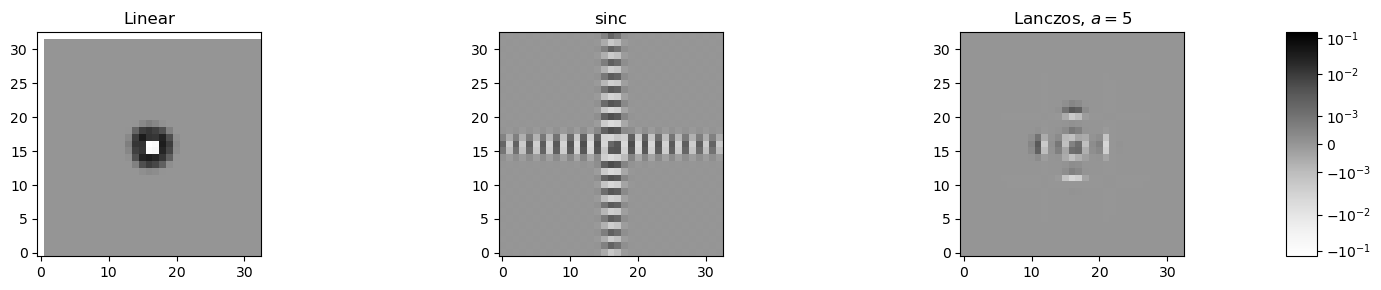

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3), gridspec_kw=dict(width_ratios=[8, 8, 8, 0.5]))

vlim = 0
for _Z in [Z_3, Z_4, Z_5]:
    vlim = max( [vlim, np.nanmax(np.abs(_Z - Z_2))] )
    
vlim = vlim / np.max(Z_2)

norms = matplotlib.colors.SymLogNorm(vlim * 0.01, vmin=-vlim, vmax=vlim)

for i, _Z in enumerate([Z_3, Z_4, Z_5]):
    im = axs[i].imshow((_Z - Z_2) / np.max(Z_2), origin='lower', norm=norms, cmap='Greys')

fig.colorbar(im, cax=axs[-1])

axs[0].set_title('Linear')
axs[1].set_title('sinc')
axs[2].set_title('Lanczos, $a=5$')

fig.tight_layout()
plt.show()

## 3. Image Centroid Accuracy

*Author: Jiarong Zhu*

This problem tests the measurement of image centroids.

(a) Write a piece of code to generate a fake, critically-sampled image of a double Gaussian, with a center that isn’t necessarily at the center of a pixel. For the second Gaussian, use A2 = 0.1A1 and σ2 = 2.47σ1, where A indicates the value at the center of the Gaussian. This choice is an approximate description of the atmospheric PSF (Jim Gunn, private communication).

(b) Write a routine to find the light-weighted centroid of the image. Start by using the maximum pixel value, and use your knowledge of the PSF FWHM to calculate the center based on the light within 3 FWHM, and iterate to convergence.

(c) Write a routine to find the mode of the image. Start by using the maximum pixel value, but then use the 3×3 grid of pixels in the center to perform a quadratic interpolation to find the peak.

(d) Now add noise to the images, and use a Monte Carlo test to evaluate how the precision of each estimate depends on the total S/N within 3 FWHM.

### 3.a. Double Gaussian Image

Generate double gaussian image. Note that to be at least critically sampled,
the FWHM of PSF should be at least 2 pixels. Here I set up (x,y) exactly
equal to index (i,j) to make life easier. The real position of the peak
is set up to be not at the center of a pixel.


In [ ]:
A1, A2 = 10, 1
sig1 = 1.
sig2 = 2.47 * sig1
xc, yc = 13.3, 14.1    #real center
a = 2 * np.sqrt(2 * np.log(2))  # a ~ 2.4
FWHM1, FWHM2 = a * sig1, a * sig2

dx, dy = 1, 1   #dx,dy<=sqrt(2*np.log(2))*sig1~1.2
x = np.arange(0, 30., dx)
y = np.arange(0.,30., dy)
xx, yy = np.meshgrid(x, y)  #xx,yy=i,j
Nx = len(x)
Ny = len(y)

z = (A1 * np.exp(- ((xx - xc)**2 + (yy - yc)**2) / (2 * sig1**2)) +
     A2 * np.exp(- ((xx - xc)**2 + (yy - yc)**2) / (2 * sig2**2)))
z = z.transpose()
#refer to value at (xx,yy): z[i,j]

plt.figure()
plt.imshow(z, cmap='gray', vmin=z.min(), vmax=z.max(),
           extent=[x.min(), x.max(), y.min(), y.max()],
           interpolation='nearest', origin='lower')
plt.title('image (nearest)')
plt.colorbar()
plt.show()

### 3.b. Light-weighted Centroid

The ight-weighted centroid can be calculated through this equation:

$x_{i,0} = \frac{\sum x_i* flux}{\sum flux}$

The FWHM of PSF should be of the same order as the maximum in {FWHM1, FWHM2}, so I use the latter to give 3FWHM range.

In [ ]:
def light_weighted_centroid(z, noise):
    data = z + noise
    index = np.where(data == np.amax(data))  # find index of pixel with maximum value
    i0, j0 = index[0].item(), index[1].item()

    R = int(3 * min(FWHM2, FWHM1) /dx)
    
    l0 = 0  # 0th order moment
    l1 = np.array([0, 0])  # 1st order moment

    for i in range(len(x)):
        for j in range(len(y)):
            if ((i - i0)**2 + (j - j0)**2 <= R**2):
                l0 = l0 + data[i, j]
                l1 = l1 + np.array([i, j]) * data[i, j]
            
    (x0, y0) = l1 / l0  #light-weighted centroid
    
    return x0, y0
           
x0,y0 = light_weighted_centroid(z, np.zeros((Nx, Ny)))
print('The light-weighted centroid: (x0, y0) = ', (x0, y0))

# 3.c. Fit Quadratic Function

Use values of 3*3 grid of pixels while the center pixel has maximum pixel value, perform quadratic fitting, i.e. fitting to function $f = c_0 + c_1 x+c_2 y +c_3 x^2 + c_4 y^2 $. With all coefficients fitted, we can estimate the centroid to be at $x_0 = - \frac{c_3}{2 c_1}, y_0 = - \frac{c_4}{2 c_2}$. Since the number of data points is 9, which is greater than the number of coefficients needed to fit, we can apply svd to make use of all data.

In [ ]:
def quad_fitting_centroid(z, noise):
    data = z + noise
    index = np.where(data == np.amax(data)) # find index of pixel with maximum value
    i0, j0 = index[0].item(),index[1].item()
    X0, X1, X2, X3, X4 = np.ones(9), [], [], [], []
    Y = []

    for i in range(i0 - 1, i0 + 2):
        for j in range(j0 - 1, j0 + 2):
            X1.append(i - i0)
            X2.append(j - j0)
            X3.append((i - i0)**2)
            X4.append((j - j0)**2)
            Y.append(np.log(data[i, j]))
        
    B = np.array([X0, X1, X2, X3, X4])  
    A = B.transpose()
    (u, w, v) = np.linalg.svd(A, full_matrices=False)
    inv_w = 1. / w 
    c = v.transpose().dot(np.diag(inv_w)).dot(u.transpose()).dot(Y)

    x0, y0 = i0 - c[1] / (2 * c[3]), j0 - c[2] / (2. * c[4])

    return x0, y0

x0, y0 = quad_fitting_centroid(z, np.zeros((Nx, Ny)))
print('The centroid estimated by quadratic fitting: (x0, y0)=', (x0, y0))

### 3.d. Effect of Noise

Add noise to the image and estimate the position of centroid by two estimators above. Use Monte Carlo to calculate Root Mean Square Error (RMSE) of the sample mean of two estimators.

In [ ]:
def RMSE_by_MC(estimator, noise_level, signal, xc, yc): #noise=noise_level*np.random.rand(Nx,Ny)
    Nx = Ny = len(signal)
    nk = 1000
    
    mse1 = []
    mse2 = []    
    
    xe = np.zeros(nk)
    ye = np.zeros(nk)
    for k in range(nk):

        noise = noise_level * np.random.randn(Nx, Ny)
        txe, tye = estimator(signal, noise)
        xe[k] = txe
        ye[k] = tye
        
    RMSE1 = np.sqrt(((xe - xc)**2).sum() / np.float32(nk))
    RMSE2 = np.sqrt(((ye - yc)**2).sum() / np.float32(nk))
    
    return RMSE1, RMSE2

R = int(min(FWHM2, FWHM1) / dx) + 1
print(FWHM2)
print(FWHM1)
print(R)
print(dx)

def SNR(z, noise_level, R):
    index = np.where(z == np.amax(z)) # find index of pixel with maximum value
    i0, j0 = index[0].item(),index[1].item()
    
    Nx = Ny = len(z)
    s = 0
    n2 = 0
    
    for i in range(Nx):
        for j in range(Ny):
            if ((i - i0)**2 + (j - j0)**2 <= R**2):
                s = s + z[i, j]
                n2 = n2 + noise_level**2 
                
    n = np.sqrt(n2)
    snr = s / n    
    return snr

noise_level = 1 #an example
snr = SNR(z, noise_level, R)
r1, r2 = RMSE_by_MC(light_weighted_centroid, noise_level, z, xc, yc)
print(r1, r2, snr) 
print(z.sum())


Below I generate a series of noises and calculate RMSEs of xc and yc for both estimators. Then plot RMSEs as a function of S/N within 3FWHM.

In [ ]:
noise_level_list = [0.05, 0.1, 0.5, 1., 2.]

snr = []
rx1,ry1 = [], []
rx2,ry2 = [], []

for noise_level in noise_level_list:
    print(noise_level)
    snr.append(SNR(z, noise_level, R))
    rrx1, rry1 = RMSE_by_MC(light_weighted_centroid, noise_level, z, xc, yc)
    rrx2, rry2 = RMSE_by_MC(quad_fitting_centroid, noise_level, z, xc, yc)
    rx1.append(rrx1)
    ry1.append(rry1)
    rx2.append(rrx2)
    ry2.append(rry2)

In [ ]:
plt.figure()
plt.plot(np.log10(snr), np.log10(rx1), color='red', linestyle='dotted', label='xc, light-weighted')
plt.plot(np.log10(snr), np.log10(ry1), color='black', linestyle='dotted', label='yc, light-weighted')
plt.plot(np.log10(snr), np.log10(rx2), color='red', label='xc, quadratic fitting')
plt.plot(np.log10(snr), np.log10(ry2), color='black', label='yc, quadratic fitting')
plt.scatter(np.log10(snr), np.log10(rx1), color='red', s=2)
plt.scatter(np.log10(snr), np.log10(ry1), color='black', s=2)
plt.scatter(np.log10(snr), np.log10(rx2), color='red', s=2)
plt.scatter(np.log10(snr), np.log10(ry2), color='black', s=2)
plt.plot(np.log10(snr), np.log10(0.685 * FWHM1 / np.array(snr)), color='yellow')
plt.xlabel('$\log_{10}$ S/N within 2 FWHM')
plt.ylabel('$\log_{10}$ error')
plt.legend()
plt.show()

The yellow line indicates $0.685~{\rm FWHM}~/~(S/N)$, which should approximate the Cramer-Rao bound (the "best possible" behavior), as discussed by Vakili & Hogg (2016; https://ui.adsabs.harvard.edu/abs/2016arXiv161005873V/abstract). So the quadratic fit centroid does pretty well.